In [183]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [435]:
from __future__ import print_function, absolute_import, division
import json
import itertools
import string
import json
import logging
import copy
import collections
import functools
import sys
import random
import warnings

from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)
from StringIO import StringIO
from markdown import markdown
from IPython.core.display import HTML, display, clear_output

from nltk.corpus import stopwords as _stopwords
from nltk.corpus import reuters
from sklearn import (manifold, cluster, metrics, cross_validation, tree, grid_search, ensemble, naive_bayes,
                     preprocessing,neighbors)
import wordcloud
import gensim as gs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from IPython.core.display import HTML, display

import preprocess_utils as pt

In [3]:
@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

In [332]:
warnings.filterwarnings('ignore')

In [4]:
np.set_printoptions(precision=5,suppress=True)

In [5]:
D2V_VEC_SIZE = 300

In [6]:
with open('/Users/kahnza2/Documents/data/frataxin_articles.json') as f:
    raw_corpus = json.load(f)

### Preparing the corpus, pre-spacy
This defines a transform manifest which is used to convert the fields of the json dictionary into the format I want.

In [7]:
transform_manifest = {key:lambda x: map(pt.depunc,gs.utils.tokenize(x,deacc=True)) for key in ['abstract', 'title']}
transform_manifest['pmid'] = lambda x: int(x)
corpus_iterable_strings = [pt.apply_transform(document, transform_manifest) for document in raw_corpus]

In [8]:
stopset = set(_stopwords.words('english'))
corpus = []
keys_to_process = keys=['abstract', 'title']
for idx, _document in enumerate(corpus_iterable_strings):
    document = pt.drop_stopwords(pt.standardize_words(_document, keys=keys),keys=keys, stopset=stopset)
    corpus.append(gs.models.doc2vec.TaggedDocument(
        document['abstract']+document['title'],[idx]))

### Preparing the corpus, post-spacy

In [9]:
nlp = spacy.en.English()

In [10]:
doc = nlp(raw_corpus[0]['abstract'])

In [11]:
doc

Fourteen patients with the clinical diagnosis of early onset cerebellar ataxia with retained tendon reflexes (EOCA) were examined and compared with 11 patients with Friedreich's ataxia (FA). The mean age of onset in EOCA was 15.9 +/- 6.0 yrs (FA: 14.0 +/- 5.7 yrs). Annual progression rate and the percentage of patients who were wheelchair-bound was lower in EOCA as compared with FA, although the difference did not reach statistical significance. The latency until becoming wheelchair-bound, however, was significantly longer in EOCA than in FA. The segregation ratio in EOCA was significantly lower than 0.25. Clinically, EOCA and FA patients presented with a progressive cerebellar syndrome. Associated symptoms, such as muscle wasting, sensory disturbances, foot deformity, scoliosis and electrocardiographic abnormalities were encountered less frequently in EOCA than in FA patients. The electrophysiological findings in EOCA were variable and pointed to axonal degeneration in peripheral nerv

In [12]:
print('\n___________________________\n'.join([str(sent.lemma_) for sent in doc.sents]))

fourteen patient with the clinical diagnosis of early onset cerebellar ataxia with retain tendon reflex ( eoca ) be examine and compare with 11 patient with friedreich 's ataxia ( fa ) .
___________________________
the mean age of onset in eoca be 15.9 +/- 6.0 yr ( fa : 14.0 +/- 5.7 yr ) .
___________________________
annual progression rate and the percentage of patient who be wheelchair - bind be low in eoca as compare with fa , although the difference do not reach statistical significance .
___________________________
the latency until become wheelchair - bind , however , be significantly longer in eoca than in fa.
___________________________
the segregation ratio in eoca be significantly low than 0.25 .
___________________________
clinically , eoca and fa patient present with a progressive cerebellar syndrome .
___________________________
associated symptom , such as muscle waste , sensory disturbance , foot deformity , scoliosis and electrocardiographic abnormality be encounter les

## NLTK stemming

In [13]:
stemmer = SnowballStemmer('english')

In [14]:
[stemmer.stem(str(tok)) for tok in doc][:10]

[u'fourteen',
 u'patient',
 u'with',
 u'the',
 u'clinic',
 u'diagnosi',
 'of',
 u'earli',
 u'onset',
 u'cerebellar']

In [15]:
lemmatizer = WordNetLemmatizer()

In [16]:
lemmatizer.lemmatize('clinically')

'clinically'

Looks like what I actually want is to do stemming on words, not lemmatization.

In [17]:
def approp_doc(doc):
    for tok in doc:
        if not tok.is_alpha:
            continue
        elif pt.is_acronym(unicode(tok)) and not tok.is_punct and not tok.is_stop and not tok.like_num:
            yield unicode(tok)
        elif not tok.like_num and not tok.is_stop and not tok.is_punct and tok.is_alpha:
            yield tok.lemma_
pipe_generator = nlp.pipe([doc_['title']+doc_['abstract'] for doc_ in raw_corpus],n_threads=1)

In [18]:
cleaned_corpus = []
for doc in pipe_generator:
    cleaned_corpus.append(list(approp_doc(doc)))

In [377]:
'|'.join(cleaned_corpus[3])

u'phosphorylation|DNA|binding|regulator|DcuR|fumarate|responsive|component|DcuSR|escherichia|coli|function|response|regulator|DcuR|DcuSR|fumarate|component|sensory|escherichia|coli|analyse|vitro|isolate|DcuR|protein|phosphorylated|sensory|histidine|kinase|DcuS|ATP|acetyl|phosphate|gel|retardation|assay|target|promoter|frdA|dcuB|dctA|phosphoryl|DcuR|DcuR|p|form|high|affinity|complex|apparent|app|microM|DcuR|p|low|affinity|app|microM|complex|high|affinity|complex|form|promoter|transcriptionally|regulate|DcuSR|low|affinity|binding|see|DcuSR|independent|promoter|bind|site|DcuR|p|dcuB|promoter|determine|DNase|footprinting|bind|site|nt|position|nt|upstream|transcriptional|start|identify|presence|low|high|concentration|DcuR|non|phosphorylated|DcuR|DcuR|mutate|phosphoryl|accept|residue|show|low|affinity|binding|target|promoter|DcuR|able|interact|DcuR|increase|phosphorylation|DcuS|competitively|inhibit|phosphoryl|transfer|wild|type'

In [376]:
print(raw_corpus[2]['title'])
raw_corpus[3]['abstract']

Lipids and lipoproteins in Friedreich's ataxia.


u'The function of the response regulator DcuR of the DcuSR fumarate two-component sensory system of Escherichia coli was analysed in vitro. Isolated DcuR protein was phosphorylated by the sensory histidine kinase, DcuS, and ATP, or by acetyl phosphate. In gel retardation assays with target promoters (frdA, dcuB, dctA), phosphoryl DcuR (DcuR-P) formed a high-affinity complex, with an apparent K(D) (app. K(D)) of 0.2-0.3 microM DcuR-P, and a low-affinity (app. K(D) 0.8-2 microM) complex. The high-affinity complex was formed only with promoters transcriptionally-regulated by DcuSR, whereas low-affinity binding was seen also with some DcuSR-independent promoters. The binding site of DcuR-P at the dcuB promoter was determined by DNase I footprinting. One binding site of 42-52 nt (position -359 to -400/-410 nt upstream of the transcriptional start) was identified in the presence of low and high concentrations of DcuR-P. Non-phosphorylated DcuR, or DcuR-D56N mutated in the phosphoryl-acceptin

In [21]:
doc = nlp(raw_corpus[1]['title']+raw_corpus[1]['abstract'])

In [22]:
for ent in doc.ents:
    print(ent,ent.label_)

Friedreich PERSON
Babinski PERSON
Friedreich ORG


In [23]:
doc

[Friedreich's ataxia and hereditary vitamin E deficiency. Case study].A 24-year-old patient, born from consanguineous parents, consulted for cerebellar syndrome, ataxia, loss of proprioception, bilateral Babinski sign and lower limbs areflexia. No mutation on Friedreich's ataxia gene was found. Plasmatic vitamin E level was extremely low. Point mutation on gene coding for alpha-tocopherol transfer protein (alpha-TTP) confirmed the diagnosis of familial isolated vitamin E deficiency (AVED). Vitamin E therapy restored normal serum levels and neurological symptoms were stabilized.

In [24]:
for tok in doc:
    if not tok.is_punct and tok.is_alpha and not tok.is_stop:
            print(tok, tok.head.lemma_)

Friedreich ataxia
ataxia deficiency
hereditary deficiency
vitamin deficiency
E deficiency
deficiency deficiency
Case consult
old patient
patient case
born case
consanguineous parent
parents from
consulted consult
cerebellar syndrome
syndrome for
ataxia syndrome
loss consult
proprioception of
bilateral sign
Babinski sign
sign proprioception
lower limb
limbs sign
areflexia consult
mutation find
Friedreich gene
ataxia gene
gene on
Plasmatic level
vitamin level
E level
level be
extremely low
low be
Point mutation
mutation confirm
gene on
coding mutation
alpha tocopherol
tocopherol protein
transfer protein
protein for
alpha ttp
TTP protein
confirmed confirm
diagnosis confirm
familial deficiency
isolated deficiency
vitamin deficiency
E deficiency
deficiency of
AVED deficiency
Vitamin therapy
E therapy
therapy restore
restored restore
normal level
serum level
levels restore
neurological symptom
symptoms level
stabilized restore


In [25]:
print(set([tok.dep_ for tok in doc]))

set([u'case', u'dobj', u'nsubj', u'cc', u'appos', u'advmod', u'det', u'nmod', u'amod', u'punct', u'auxpass', u'pobj', u'nsubjpass', u'prep', u'compound', u'conj', u'acl', u'ROOT', u'poss', u'acomp'])


In [26]:
cleaned_corpus_strings = []
for idx,doc in enumerate(cleaned_corpus):
    cleaned_corpus_strings.append(gs.models.doc2vec.TaggedDocument(words=doc,tags=[idx]))

In [27]:
id2word = gs.corpora.Dictionary(documents=cleaned_corpus)
known_words = set(id2word.values())
id2word.filter_extremes(2,0.9)

In [28]:
filtered_corpus = []
for idx,doc in enumerate(cleaned_corpus):
    filtered_corpus.append(gs.models.doc2vec.TaggedDocument(words=[word for word in doc if word in known_words],tags=[idx]))

In [29]:
len(id2word)

6588

In [30]:
model = gs.models.Doc2Vec(documents=filtered_corpus,min_count=0,workers=2,size=300,window=10,dbow_words=1)

In [31]:
model.vocab.keys()[-10:]

[u'coupling',
 u'porphyria',
 u'cuneate',
 u'osteopetrosis',
 u'emery',
 u'subscore',
 u'riboflavin',
 u'unverricht',
 u'bcr',
 u'coactivation']

In [32]:
model.most_similar('bcr')

[(u'growth', 0.7200939655303955),
 (u'anaerobic', 0.7116987109184265),
 (u'aerobic', 0.6896543502807617),
 (u'property', 0.6803722977638245),
 (u'cycle', 0.6762419939041138),
 (u'synthesize', 0.6674469709396362),
 (u'inducible', 0.6557919979095459),
 (u'microscopy', 0.6556148529052734),
 (u'defense', 0.6540102362632751),
 (u'maintain', 0.6528592109680176)]

In [33]:
model.most_similar('FXN')

[(u'gene', 0.9307754039764404),
 (u'transcription', 0.8871394991874695),
 (u'silence', 0.8855202198028564),
 (u'elongation', 0.853752613067627),
 (u'deletion', 0.8467554450035095),
 (u'silencing', 0.8350776433944702),
 (u'clone', 0.8323711156845093),
 (u'exon', 0.8309024572372437),
 (u'DNA', 0.825502336025238),
 (u'repression', 0.8172047138214111)]

In [34]:
model.most_similar('riboflavin')

[(u'classical', 0.6463929414749146),
 (u'ataxy', 0.6443823575973511),
 (u'ataxia', 0.6340795755386353),
 (u'myocardiopathy', 0.632083535194397),
 (u'catecholamine', 0.6294775605201721),
 (u'quality', 0.6159369945526123),
 (u'nikolaus', 0.605842113494873),
 (u'involvement', 0.5806137919425964),
 (u'survival', 0.5750750303268433),
 (u'dentate', 0.5704149007797241)]

In [35]:
dmatrix = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(model.syn0,metric='cosine'))

In [36]:
rows, cols = np.diag_indices_from(dmatrix)

In [37]:
dmatrix[rows, cols] = np.inf

### Is it possible to add more sentences to each document by generating noun phrases from the dependency graph?

In [38]:
doc = nlp(raw_corpus[3]['abstract'])

In [39]:
print(' '.join(str(x) for x in doc.noun_chunks))

The function the response regulator the DcuSR fumarate two-component sensory system Escherichia coli vitro Isolated DcuR protein the sensory histidine kinase acetyl phosphate gel retardation assays target promoters a high-affinity complex an apparent K(D The high-affinity complex promoters low-affinity binding some DcuSR-independent promoters The binding site the dcuB promoter One binding site the transcriptional start the presence low and high concentrations the phosphoryl-accepting Asp56 residue low-affinity binding promoters the phosphorylation phosphoryl transfer wild-type DcuR.


In [40]:
doc

The function of the response regulator DcuR of the DcuSR fumarate two-component sensory system of Escherichia coli was analysed in vitro. Isolated DcuR protein was phosphorylated by the sensory histidine kinase, DcuS, and ATP, or by acetyl phosphate. In gel retardation assays with target promoters (frdA, dcuB, dctA), phosphoryl DcuR (DcuR-P) formed a high-affinity complex, with an apparent K(D) (app. K(D)) of 0.2-0.3 microM DcuR-P, and a low-affinity (app. K(D) 0.8-2 microM) complex. The high-affinity complex was formed only with promoters transcriptionally-regulated by DcuSR, whereas low-affinity binding was seen also with some DcuSR-independent promoters. The binding site of DcuR-P at the dcuB promoter was determined by DNase I footprinting. One binding site of 42-52 nt (position -359 to -400/-410 nt upstream of the transcriptional start) was identified in the presence of low and high concentrations of DcuR-P. Non-phosphorylated DcuR, or DcuR-D56N mutated in the phosphoryl-accepting 

In [229]:
noun_corpus = []
for doc in nlp.pipe([doc_['title']+doc_['abstract'] for doc_ in raw_corpus]):
    noun_corpus.append(list(itertools.chain.from_iterable([approp_doc(phrase) for phrase in doc.noun_chunks])))

In [241]:
noun_corpus_tagged = [gs.models.doc2vec.TaggedDocument(
        words=[word for word in words if word in known_words], tags=[idx]) for idx, words in enumerate(noun_corpus)]

In [257]:
noun_model = gs.models.Doc2Vec(documents=noun_corpus_tagged,min_count=0,workers=2,size=300,window=10,dbow_words=1)

In [267]:
noun_model.most_similar('riboflavin')

[(u'axon', 0.5322227478027344),
 (u'grow', 0.5254589319229126),
 (u'pathological', 0.5164415836334229),
 (u'thoracic', 0.5095628499984741),
 (u'significance', 0.5067158341407776),
 (u'health', 0.5051459074020386),
 (u'speed', 0.5004512071609497),
 (u'nucleus', 0.4983372688293457),
 (u'mode', 0.4960317313671112),
 (u'foot', 0.4932441711425781)]

In [259]:
noun_model.most_similar('FXN')

[(u'replication', 0.9214732646942139),
 (u'sequence', 0.9141572713851929),
 (u'coding', 0.9097259044647217),
 (u'mRNA', 0.906334400177002),
 (u'conformation', 0.9053191542625427),
 (u'repair', 0.9015089273452759),
 (u'methylation', 0.8923825621604919),
 (u'genomic', 0.8920159935951233),
 (u'gene', 0.8896386623382568),
 (u'DNA', 0.8860011100769043)]

In [265]:
noun_model.most_similar('reductase')

[(u'operon', 0.9403022527694702),
 (u'terminal', 0.9361766576766968),
 (u'fumarate', 0.92973792552948),
 (u'anaerobic', 0.9009178280830383),
 (u'growth', 0.8999775648117065),
 (u'target', 0.8949384689331055),
 (u'electron', 0.8938944935798645),
 (u'nitrate', 0.8914185762405396),
 (u'subunit', 0.8909289240837097),
 (u'respiration', 0.8805306553840637)]

In [266]:
noun_model.most_similar('bcr')

[(u'image', 0.553923487663269),
 (u'protective', 0.5520947575569153),
 (u'derive', 0.5507909059524536),
 (u'zinc', 0.5499081611633301),
 (u'inducible', 0.5496088266372681),
 (u'superoxide', 0.5334028005599976),
 (u'surface', 0.5322036743164062),
 (u'substantial', 0.5321758389472961),
 (u'assay', 0.5312786102294922),
 (u'amount', 0.5298240780830383)]

### Walking the graph of a document

In [41]:
for tok in doc:
    if tok.dep_ != 'ROOT':
        continue
    else:
        print(tok, '---->',list(tok.children))
    

analysed ----> [function, was, in, .]
phosphorylated ----> [protein, was, by, .]
formed ----> [In, (, DcuR, complex, ,, with, )]
app ----> [(, .]
K(D ----> [), ), of, ,, and, app, .]
complex ----> [K(D, microM, .]
formed ----> [complex, was, with, ,, seen, .]
determined ----> [site, was, by, footprinting, .]
identified ----> [site, was, in, mutated, .]
was ----> [D56N, still, able, increased]


In [42]:
dfs_walks = []
for tok in doc:
    is_term = list(tok.children)
    if not is_term:
        tok_ = tok
        dfs_walk = []
        while tok_ is not tok_.head:
            dfs_walk.append(tok_)
            tok_ = tok_.head
        dfs_walks.append(dfs_walk)

In [43]:
doc

The function of the response regulator DcuR of the DcuSR fumarate two-component sensory system of Escherichia coli was analysed in vitro. Isolated DcuR protein was phosphorylated by the sensory histidine kinase, DcuS, and ATP, or by acetyl phosphate. In gel retardation assays with target promoters (frdA, dcuB, dctA), phosphoryl DcuR (DcuR-P) formed a high-affinity complex, with an apparent K(D) (app. K(D)) of 0.2-0.3 microM DcuR-P, and a low-affinity (app. K(D) 0.8-2 microM) complex. The high-affinity complex was formed only with promoters transcriptionally-regulated by DcuSR, whereas low-affinity binding was seen also with some DcuSR-independent promoters. The binding site of DcuR-P at the dcuB promoter was determined by DNase I footprinting. One binding site of 42-52 nt (position -359 to -400/-410 nt upstream of the transcriptional start) was identified in the presence of low and high concentrations of DcuR-P. Non-phosphorylated DcuR, or DcuR-D56N mutated in the phosphoryl-accepting 

In [44]:
def dependency_labels_to_root(token):
    '''Walk up the syntactic tree, collecting the arc labels.'''
    dep_labels = []
    while token.head is not token:
        dep_labels.append(token.dep)
        token = token.head
    return dep_labels

In [45]:
dependency_labels_to_root(tok)

[401, 405, 380, 375, 375]

In [47]:
def graph_walks(doc):
    walks = []
    for tok in doc:
        is_term = list(tok.children)
        if not is_term:
            tok_ = tok
            walk = []
            while tok_ is not tok_.head:
                walk.append(tok_)
                tok_ = tok_.head
            else:
                walk.append(tok_)
            walks.append(walk)
    return walks

In [48]:
all_walks_pipe = nlp.pipe([doc_['title']+doc_['abstract'] for doc_ in raw_corpus],n_threads=1)
all_walks_corpus = [list(approp_doc(itertools.chain.from_iterable(graph_walks(doc_)))) for doc_ in all_walks_pipe]

In [49]:
all_walks_corpus = [gs.models.doc2vec.TaggedDocument(words=words, tags=[idx]) for idx, words in enumerate(all_walks_corpus)]

In [72]:
all_walks_model = gs.models.Doc2Vec(documents=all_walks_corpus,min_count=0,workers=2,size=300,window=10,dbow_words=0)

In [73]:
all_walks_model.most_similar('FXN')

[(u'encoding', 0.6583304405212402),
 (u'gene', 0.6397207975387573),
 (u'expression', 0.6084086894989014),
 (u'intron', 0.6031765937805176),
 (u'frataxin', 0.4965081512928009),
 (u'tat', 0.48622697591781616),
 (u'transgene', 0.4706765413284302),
 (u'MIPEP', 0.4664611220359802),
 (u'silence', 0.4585033059120178),
 (u'quantitation', 0.4552176892757416)]

In [74]:
all_walks_model.most_similar('riboflavin')

[(u'thiamin', 0.8278229236602783),
 (u'carotene', 0.6438639163970947),
 (u'folate', 0.6011594533920288),
 (u'assess', 0.5333079099655151),
 (u'histology', 0.48635151982307434),
 (u'OCT', 0.477713942527771),
 (u'register', 0.46769994497299194),
 (u'plus', 0.464294970035553),
 (u'underestimate', 0.46135807037353516),
 (u'adapt', 0.4497045576572418)]

In [75]:
all_walks_model.most_similar('bcr')

[(u'oxidase', 0.6209160685539246),
 (u'mesylate', 0.5538539290428162),
 (u'disrupt', 0.5318471193313599),
 (u'obtainable', 0.4978700280189514),
 (u'HDCBAP', 0.4869064390659332),
 (u'adenocarcinoma', 0.4666649401187897),
 (u'ATLD', 0.44243913888931274),
 (u'investigate', 0.43880578875541687),
 (u'responsive', 0.43829426169395447),
 (u'upregulation', 0.43542927503585815)]

In [76]:
all_walks_model.most_similar('protein')

[(u'frataxin', 0.6609944105148315),
 (u'encode', 0.6061965823173523),
 (u'scaffold', 0.548318088054657),
 (u'conserve', 0.5299305319786072),
 (u'CyaY', 0.5075977444648743),
 (u'TALE', 0.49336615204811096),
 (u'IRE', 0.48121076822280884),
 (u'accessory', 0.48034727573394775),
 (u'mitochondrial', 0.47782430052757263),
 (u'matrix', 0.4575484097003937)]

In [77]:
def colorgreen(iterable):
    fmt_str = '<span style="color:red">{}</span>'
    return [fmt_str.format(elem) for elem in iterable]

In [78]:
df = pd.concat([pd.DataFrame.from_dict({key:zip(*all_walks_model.most_similar(key))[0] for 
                                        key in ['FXN', 'bcr', 'riboflavin',
                                                                                  'oxidase','protein']}),
          pd.DataFrame.from_dict({key+'Previous':zip(*model.most_similar(key))[0] for key in ['FXN', 'bcr', 'riboflavin',
                                                                                   'oxidase', 'protein']})],
         axis=1)

In [79]:
df[df.columns.sort_values()].style.\
applymap(lambda values,axis: 'background-color: orange',
                  axis=0, subset=['FXNPrevious','bcrPrevious','riboflavinPrevious','oxidasePrevious','proteinPrevious']).\
applymap(lambda values,axis:'background-color: #64FE2E',
        axis=0, subset=['FXN', 'bcr', 'oxidase','protein','riboflavin'])

In [80]:
def color_changed(whole_df):
    whole_df_ = whole_df.copy()
    for key in ['FXN', 'bcr', 'oxidase','protein','riboflavin']:
        whole_df_[key] = ''
        whole_df_[key+'Previous'] = ''
        for idx, elem in enumerate(whole_df[key]):
            if not np.count_nonzero(elem==whole_df[key+'Previous']):
                whole_df_.iloc[idx][key] = 'color: #DF01A5'
    return whole_df_

In [81]:
df[df.columns.sort_values()].style.apply(color_changed, axis=None).\
applymap(lambda values,axis: 'background-color: #D8D8D8',
                  axis=0, subset=['FXNPrevious','bcrPrevious','riboflavinPrevious','oxidasePrevious','proteinPrevious'])

### Normal Corpora vs Scientific Corpora
How does the syntatic dependency depth and branch point number of documents in normal corpora differ from those in scientfic corpora?

In [82]:
abstract_avg_length = np.mean([len(list(doc)) for doc in nlp.pipe([doc_['title']+doc_['abstract'] for doc_ in raw_corpus])])

In [83]:
acceptable_reuters = [fileid for fileid in reuters.fileids() if 150<=len(reuters.words(fileid))<=350]

In [84]:
reuters_avg_length = np.mean([len(reuters.words(fileid)) for fileid in acceptable_reuters[:2104]])

In [85]:
reuters_raw = [' '.join(reuters.words(fileid)) for fileid in acceptable_reuters[:2104]]

In [86]:
reuters_walks = [[list(approp_doc(line)) for line in graph_walks(nlp(doc))] for doc in reuters_raw]

In [87]:
abstract_walks = [[list(approp_doc(line)) for line in graph_walks(doc)] for doc in nlp.pipe([doc_['title']+doc_['abstract'] for doc_ in raw_corpus])]

In [88]:
reuters_maxdepth = [reduce(lambda x,y: max(x,len(y)),line,0) for line in reuters_walks]
abstract_maxdepth = [reduce(lambda x,y: max(x,len(y)),line,0) for line in abstract_walks]
maxdepth_df = pd.DataFrame()
maxdepth_df['Reuters'] = reuters_maxdepth
maxdepth_df['Abstracts'] = abstract_maxdepth
avg_length_df = pd.DataFrame()
avg_length_df['Reuters']= [np.mean(map(len,doc)) for doc in reuters_walks]
avg_length_df['Abstracts'] = [np.mean(map(len,doc)) for doc in abstract_walks]

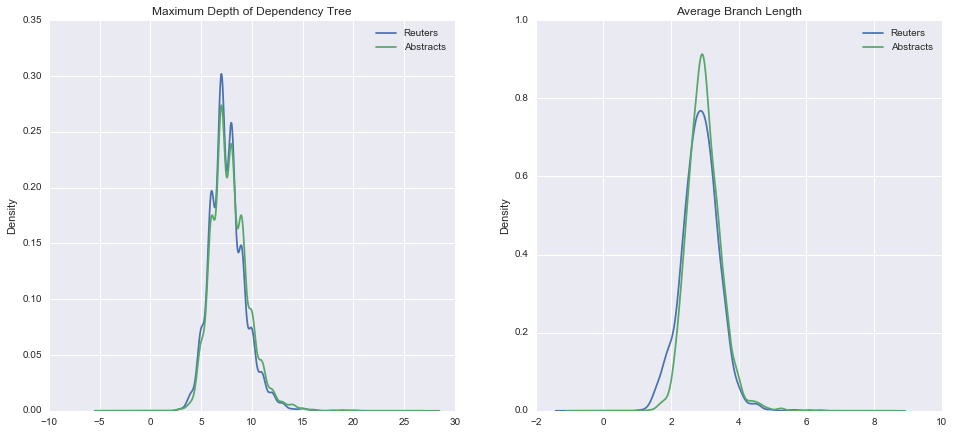

In [89]:
display(HTML(u'<span style="color:green">Average Abstract Length: {}</span>'.format(int(abstract_avg_length))))
display(HTML(u'<span style="color:blue">Average Reuters Length: {}</span>'.format(int(reuters_avg_length))))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,7))
maxdepth_df.plot(kind='kde',title='Maximum Depth of Dependency Tree',ax=ax1)
avg_length_df.plot(kind='kde', title='Average Branch Length',ax=ax2)

(-100, 1000)

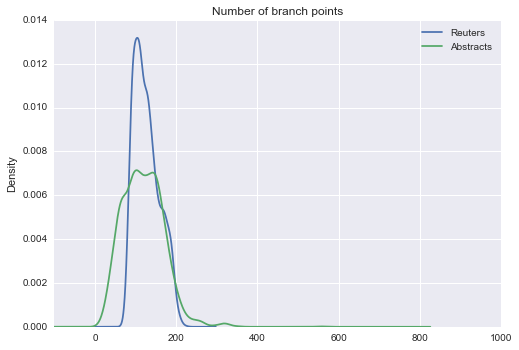

In [90]:
reuters_branch_num = [len(doc) for doc in reuters_walks]
abstract_branch_num = [len(doc) for doc in abstract_walks]
branch_num_df = pd.DataFrame()
branch_num_df['Reuters'] = reuters_branch_num
branch_num_df['Abstracts'] = abstract_branch_num
branch_num_df.plot(kind='kde',title='Number of branch points')
plt.xlim(-100,1000)

In [91]:
reuters_avg_length = np.mean([len(reuters.words(fileid)) for fileid in reuters.fileids()[:2104]])

In [92]:
all_walks_matrix = np.matrix(all_walks_model.docvecs)
pd.to_pickle(all_walks_matrix,'/Users/kahnza2/Documents/all_walks_matrix.pkl')

### Clustering the words

In [93]:
all_walks_word_features = np.matrix(all_walks_model.syn0)

In [94]:
all_walks_word_distance = metrics.pairwise.cosine_distances(all_walks_word_features)
all_walks_word_distance_condensed = scipy.spatial.distance.pdist(all_walks_word_features,metric='cosine')

In [728]:
np.min(all_walks_word_similarity), np.max(all_walks_word_similarity)

(6.2472194e-05, 1485.4528)

In [100]:
def make_kde(cls_id,**kwargs):
    return sns.kdeplot(pd.Series(cls_id).value_counts(),shade=True,**kwargs)

In [101]:
def custom_connectivity(idx,topn=5):
    words, distances = zip(*all_walks_model.most_similar(all_walks_model.index2word[idx],topn=topn))
    return [all_walks_model.vocab[word].index for word in words]

In [102]:
def get_word_cluster(word, Y):
    word_cls = Y[all_walks_model.vocab[word].index]
    return [all_walks_model.index2word[idx] for idx in np.argwhere(Y==word_cls)]
    

In [124]:
Z_w2v_all_walks = scipy.cluster.hierarchy.linkage(all_walks_word_distance_condensed,'complete', metric='cosine')

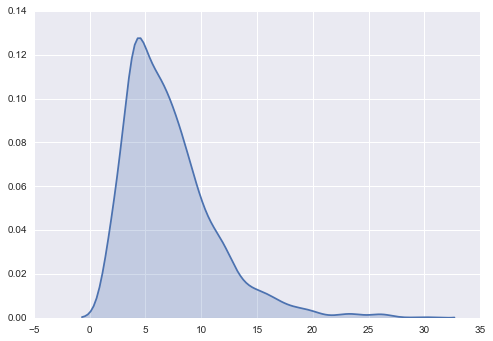

In [132]:
Z_w2v_id_all_walks = scipy.cluster.hierarchy.fcluster(Z_w2v_all_walks,0.95, criterion='distance')
make_kde(Z_w2v_id_all_walks)

In [134]:
get_word_cluster('riboflavin',Z_w2v_id_all_walks)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()


[u'riboflavin',
 u'post',
 u'thiamin',
 u'translational',
 u'CpG',
 u'carotene',
 u'histology',
 u'MICARS',
 u'industrialize',
 u'BARS']

In [139]:
get_word_cluster('CPOX',Z_w2v_id_all_walks)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()


[u'mean',
 u'multiple',
 u'SD',
 u'olivopontocerebellar',
 u'robot',
 u'faster',
 u'gram',
 u'discomfort',
 u'leukodystrophy',
 u'false',
 u'CPOX',
 u'arrthymias',
 u'forties',
 u'SEM',
 u'phaeochromocytoma',
 u'coproporphyrinogen',
 u'ketosis',
 u'coA',
 u'somedic',
 u'myelinization',
 u'FCCA',
 u'neurophysiopathologic',
 u'handheld',
 u'phosphatidyl']

In [162]:
def find_merge(word, linkage):
    w_max = len(all_walks_model.vocab)
    word_idx = all_walks_model.vocab[word].index
    merge_locations = linkage[np.logical_or(linkage[:,0]==word_idx,linkage[:,1]==word_idx)].ravel()
    return all_walks_model.index2word[int(merge_locations[1])], merge_locations[2]

In [163]:
find_merge('FXN', Z_w2v_all_walks)

(u'encoding', 0.34166957676667031)

In [167]:
find_merge('oxidase',Z_w2v_all_walks)

(u'COX', 0.28521163023971319)

In [169]:
find_merge('riboflavin',Z_w2v_all_walks)

(u'thiamin', 0.172177045415005)

In [170]:
find_merge('protein',Z_w2v_all_walks)

(u'frataxin', 0.33900562452284488)

# <span style="background-color:#A5DF00">Replacing Words by the Cluster They Belong To</span>

In [229]:
def cluster_representative(features, cluster_num, assignments):
        batch = assignments==cluster_num
        minor_dmatrix = scipy.spatial.distance.squareform(
            scipy.spatial.distance.pdist(features[batch],metric='cosine'))
        center = np.argmin(np.mean(minor_dmatrix,axis=1))
        return all_walks_model.index2word[np.argwhere(batch)[center]]

In [231]:
print(cluster_representative(all_walks_word_features,50,Z_w2v_id_all_walks))
print(get_word_cluster(cluster_representative(all_walks_word_features,50,Z_w2v_id_all_walks),Z_w2v_id_all_walks))

chemotherapy
[u'primary', u'anti', u'apoptotic', u'chemotherapy', u'vesicular', u'centrifugation']


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  app.launch_new_instance()


In [242]:
Z_w2v_id_all_walks_counts = pd.Series(Z_w2v_id_all_walks).value_counts()
acceptable_clusters = set(Z_w2v_id_all_walks_counts[np.logical_and(2<=Z_w2v_id_all_walks_counts,
                                                               Z_w2v_id_all_walks_counts<=10)].index)

In [245]:
w_remap = {word:cluster_representative(
        all_walks_word_features,
        Z_w2v_id_all_walks[w_id],
        Z_w2v_id_all_walks) for w_id,word in enumerate(all_walks_model.index2word) if Z_w2v_id_all_walks[w_id] in acceptable_clusters}

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [273]:
replacement_targets = set(w_remap.keys())
all_walks_corpus_remapped = map(lambda entry:
                                [u'<@{}>'.format(w_remap[word]) if word in replacement_targets else word for word in entry.words],
                               all_walks_corpus)

In [278]:
id2word = gs.corpora.Dictionary(all_walks_corpus_remapped)
id2word.filter_extremes(no_below=2,no_above=1.0)

In [284]:
all_walks_corpus_remapped_bow = gs.matutils.corpus2dense([id2word.doc2bow(doc) for doc in all_walks_corpus_remapped],
                                                        num_terms=len(id2word),
                                                        num_docs = len(all_walks_corpus_remapped)).T

In [343]:
original_corpus_remapped = map(lambda entry:
                               ' '.join([u'<span style="color:blue">+{}</span>'.format(w_remap[word]) if 
                                word in replacement_targets else word for word in entry['title'].split()]),
                               raw_corpus)

# <span style="background-color:#A5DF00">Clustering The Corpus</span>

In [295]:
condensed_distance = scipy.clip(scipy.spatial.distance.pdist(all_walks_corpus_remapped_bow,metric='cosine'),0,100)
Z_d2v = scipy.cluster.hierarchy.linkage(condensed_distance,method='complete',metric='cosine')


In [297]:
c_d2v, coph_dists_d2v = scipy.cluster.hierarchy.cophenet(Z_d2v,condensed_distance)
print(c_d2v)

0.366209197358


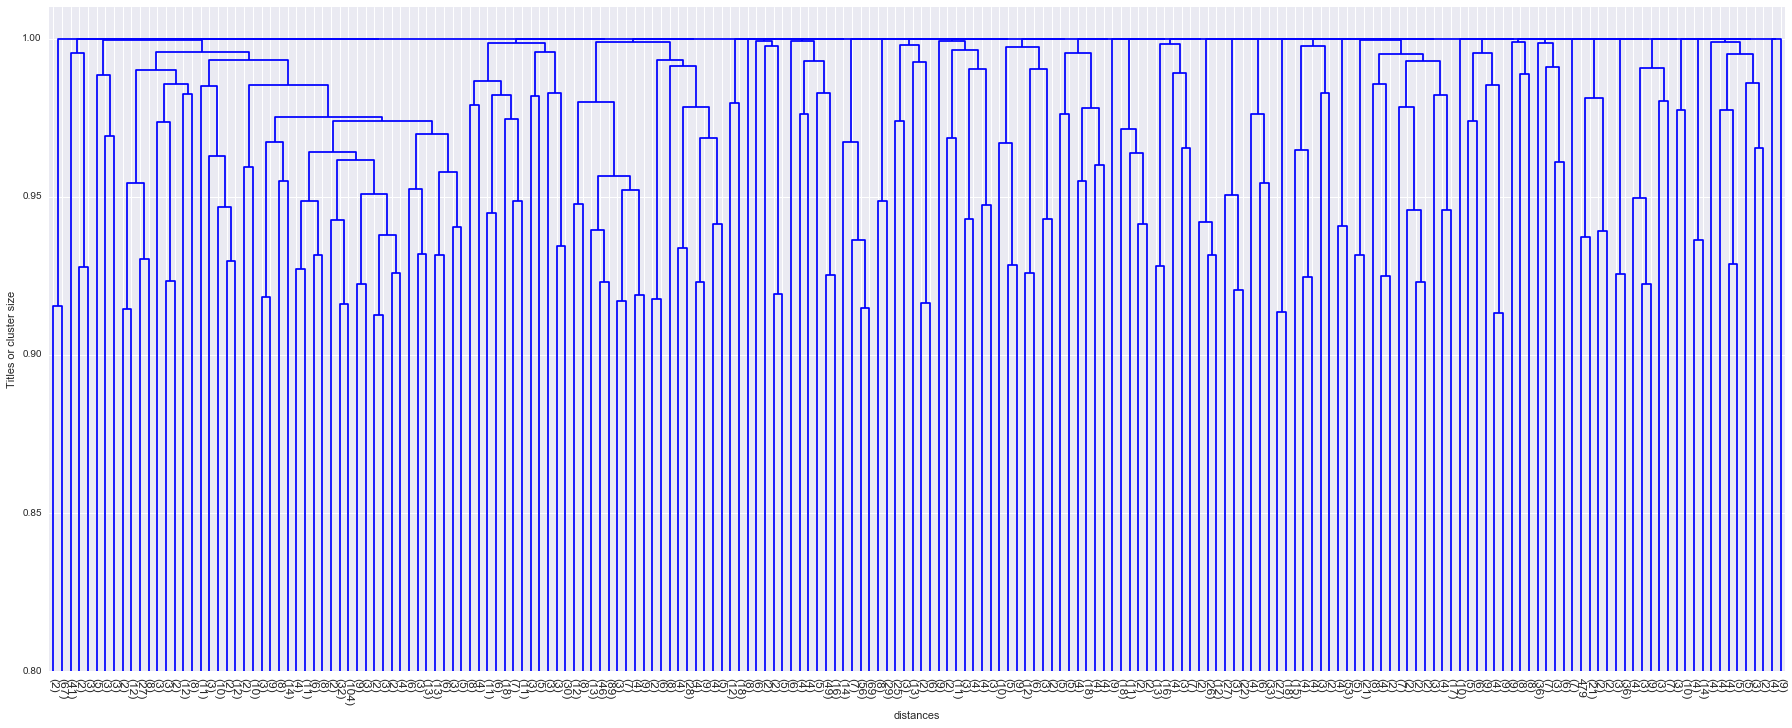

In [300]:
fig = plt.figure(figsize=(25,10))
plt.ylabel('Titles or cluster size')
plt.xlabel('distances')
plt.tight_layout()
scipy.cluster.hierarchy.dendrogram(Z_d2v,truncate_mode='lastp',show_leaf_counts='false',
                                  leaf_rotation=270,
                                  orientation='top',
                                  p=200,
                                  leaf_font_size=12)
plt.ylim(0.8,1.01)
plt.show()

In [422]:
Z_d2v_id = scipy.cluster.hierarchy.fcluster(Z_d2v,50,criterion='maxclust')

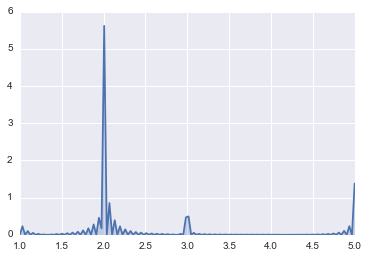

In [565]:
make_kde(pd.Series(Z_d2v_id).value_counts())

In [303]:
pd.to_pickle(Z_d2v_id,'Z_d2v_id_w_replace.pkl')

In [401]:
for idx in np.argwhere(Z_d2v_id==33):
    line = original_corpus_remapped[idx]
    #display(HTML(line))
    oldline = raw_corpus[idx]['title'].split()
    display(HTML(' '.join(
                [word if word in line.split() else '<span style="color:red">-{}</span>'.format(word) for word in oldline])))

## Visualizing the Spread of Documents containing FXN and frataxin

In [404]:
FXN_docs = [idx for idx,doc in enumerate(all_walks_corpus) if 'FXN' in doc.words]
frataxin_docs = [idx for idx,doc in enumerate(all_walks_corpus) if 'frataxin' in doc.words]
both_docs = [idx for idx, doc in enumerate(all_walks_corpus) if 'frataxin' in doc.words and 'FXN' in doc.words]

In [408]:
pd.to_pickle({'FXN':FXN_docs,'frataxin':frataxin_docs,'both':both_docs},'fxn_frat.pkl')

## Discriminative Words for Each Cluster

In [423]:
class_performance_dict = pt.one_vs_rest_clf(all_walks_corpus_remapped_bow,Z_d2v_id)

label 50


In [557]:
def color_words(word, color='blue'):
    if word.startswith('@'):
        word_emph = u'<span style="color:{color}">{word}</span> '.format(color=color, word=word)
        cls_partners = u' | '.join(get_word_cluster(word[1:],Z_w2v_id_all_walks))
        return display(HTML(word_emph+u'<i>{}</i>'.format(cls_partners)))
    else:
        return display(HTML(u'<b><span style="color:#08BB92">{}</span><b>'.format(word)))

In [566]:
for word in pt.best_estimator_word_display(class_performance_dict[29].best_estimator_,id2word,topn=15):
    color_words(word, color='blue')

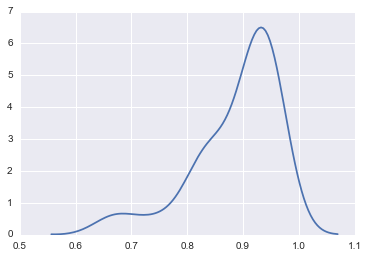

In [531]:
sns.kdeplot(np.array([gs_obj.best_score_ for gs_obj in class_performance_dict.itervalues()]))